In [2]:
from pandas import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.axes as axes
from itertools import product
import random
from scipy.stats import t, norm

import warnings
warnings.filterwarnings("ignore")


from arch import arch_model
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [3]:
####################################### EXTRACTION & FORMATTING #######################################

data = pd.read_csv("C:\\Users\\elaar\\OneDrive\\Bureau\\COURS\\Dauphine Master 203\\M2\\ATS\\adidas_cds_data.csv")
data.Date = pd.to_datetime(data.Date)
data.ref_index = data.index
data.index = data.Date
data['quarter'] = data.index.quarter
data.index = data.ref_index
data



,Date,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10,quarter
0,2015-01-01,ADSGR,adidas AG,22.5300,29.9850,39.0550,50.8500,61.2700,67.6650,72.9000,75.5000,78.4000,80.2050,1
1,2015-01-02,ADSGR,adidas AG,22.7300,30.1850,39.2550,50.8000,61.3700,67.7650,72.8950,75.4400,78.3400,80.1350,1
2,2015-01-05,ADSGR,adidas AG,22.5300,30.2050,39.6150,51.2700,62.2500,68.5650,73.5550,76.2500,79.1400,80.9950,1
3,2015-01-06,ADSGR,adidas AG,23.0200,31.2150,40.7450,52.2300,62.9800,69.0650,74.1150,76.6200,79.3800,81.2050,1
4,2015-01-07,ADSGR,adidas AG,23.0000,31.2000,40.6950,52.2900,63.0000,68.9450,73.8050,76.2500,79.0500,80.9250,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,2021-09-06,ADSGR,adidas AG,12.4655,19.4391,27.0629,34.2915,41.0055,49.0567,54.6324,59.8869,63.9610,67.3294,3
1743,2021-09-07,ADSGR,adidas AG,12.6962,19.6142,27.4040,34.7736,41.5720,49.5966,55.1507,60.4310,64.5274,67.9144,3
1744,2021-09-08,ADSGR,adidas AG,12.5577,19.5188,27.2419,34.6059,41.4020,49.4110,54.9554,60.1727,64.2204,67.5696,3
1745,2021-09-09,ADSGR,adidas AG,12.5471,19.6140,27.3028,34.7478,41.6134,49.7047,55.2992,60.5609,64.6446,68.0239,3


In [4]:
####################################### INITIALISAITON & QTRLY RETURNS #######################################

dataset = data.PX10
data["qtrly_ret"] = np.zeros(shape=np.shape(dataset))
#qrtly_idx = list(data[((data.Date - data.Date.iloc[0]).dt.days % 90 == 0)].index)
qrtly_idx = [0]


for idx in data.index:

    if idx < data.quarter.ne(data.quarter.iloc[0]).idxmax(): 
        # ignores all the values in from the 1st quarter since we cannot compute their quarterly returns 
        last_ret = np.nan
    
    else:
        prev_quarter = data.quarter.iloc[idx -1]
        current_quarter = data.quarter.iloc[idx]
        if current_quarter != prev_quarter:
            qrtly_idx.append(idx)
            last_ret = (dataset.iloc[idx] - dataset.iloc[qrtly_idx[-2]])/dataset.iloc[qrtly_idx[-2]]
    data.qtrly_ret.iloc[idx] = last_ret
    
data.qtrly_ret

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1742   -0.075468
1743   -0.075468
1744   -0.075468
1745   -0.075468
1746   -0.075468
Name: qtrly_ret, Length: 1747, dtype: float64

In [5]:
# Dataframe with only dates and the quarterly returns
qtrly_ret = data.qtrly_ret.to_frame()
qtrly_ret.drop_duplicates(inplace=True)
qtrly_ret.index=data.Date.filter(data.qtrly_ret.drop_duplicates().index)
qtrly_ret.dropna(inplace=True)
qtrly_ret

,qtrly_ret
Date,
2015-04-01,0.033726
2015-07-01,0.106561
2015-10-01,0.211837
2016-01-01,-0.191716
2016-04-01,0.042564
2016-07-01,0.050165
2016-10-03,0.135176
2017-01-02,-0.148447
2017-04-03,-0.003049


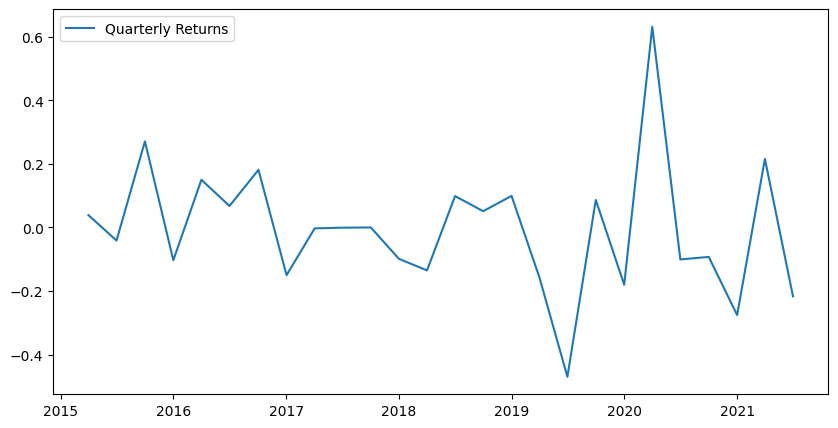

In [24]:
# Plot the the quarterly returns
plt.figure(figsize=(10,5))
plt.plot(qtrly_ret, label = 'Quarterly Returns')
plt.legend()
plt.show()

In [25]:
ts = sm.tsa.arima.ARIMA(np.ravel(qtrly_ret), order=(1,0,1))
results_arma_2_1 = ts.fit()
results_arma_2_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   26
Model:                 ARIMA(1, 0, 1)   Log Likelihood                   6.505
Date:                Thu, 22 Dec 2022   AIC                             -5.010
Time:                        21:42:44   BIC                              0.023
Sample:                             0   HQIC                            -3.561
                                 - 26                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.050     -0.074      0.941      -0.102       0.094
ar.L1         -0.9494      0.231     -4.117      0.000      -1.401      -0.497
ma.L1          0.7892      0.370      2.136      0.033       0.065       1.513
sigma2         0.0348      0.007      4.783      0.000       0.021       0.049
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.53
Prob(Q):                              0.99   Prob(JB):                         0.02
Heteroskedasticity (H):               5.63   Skew:                             0.29
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
#===========================================================================
# estimate ARMA 
#===========================================================================

ar_order = [0, 1, 2, 3]
ma_order = [0, 1, 2, 3]
arma_res = [[x,y,0] for x,y in product(ar_order, ma_order)]

#     pprint.pprint(arma_res)

for order in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*order)) 
    try:
        arma_model  = sm.tsa.arima.ARIMA(np.ravel(qtrly_ret), order=order).fit()
        print("aic ",arma_model.aic , " bic ",arma_model.bic)
    except Exception as exception:
        print(exception.__str__())


fitting: ar:0 - ma:0
aic  -4.644994567309011  bic  -2.1288014912660467
fitting: ar:0 - ma:1
aic  17.594796984735652  bic  18.813672809603855
fitting: ar:0 - ma:2
aic  45.93106011041857  bic  47.10911394076652
fitting: ar:0 - ma:3
aic  73.48408335779  bic  74.61957757371914
fitting: ar:1 - ma:0
aic  -4.663276728397831  bic  -0.8889871143333838
fitting: ar:1 - ma:1
aic  5.687233271307919  bic  8.12498492104432
fitting: ar:1 - ma:2
aic  21.792501913265887  bic  24.148609573961778
fitting: ar:1 - ma:3
aic  40.51835121800311  bic  42.78933964986141
fitting: ar:2 - ma:0
aic  -2.8461561265921524  bic  2.186230025493776
fitting: ar:2 - ma:1
aic  7.6747006808222125  bic  11.331328155426814
fitting: ar:2 - ma:2
aic  23.05709817191586  bic  26.5912596629597
fitting: ar:2 - ma:3
aic  39.39472622672098  bic  42.801208874508426
fitting: ar:3 - ma:0
aic  -8.364053687284851  bic  -2.073570997177441
fitting: ar:3 - ma:1
aic  2.9386663773192225  bic  7.814169676792025
fitting: ar:3 - ma:2
aic  20.902949

In [48]:
#-------------------------------------------------------------------------------------
#from the previous test, we choose to go with the arma(2,0), also known as the AR(2)
#-------------------------------------------------------------------------------------
arma_model  = sm.tsa.arima.ARIMA(np.ravel(qtrly_ret),order=(2,0,0)).fit()
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   26
Model:                 ARIMA(2, 0, 0)   Log Likelihood                   5.423
Date:                Thu, 22 Dec 2022   AIC                             -2.846
Time:                        21:59:59   BIC                              2.186
Sample:                             0   HQIC                            -1.397
                                 - 26                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.044     -0.082      0.935      -0.090       0.083
ar.L1         -0.2529      0.347     -0.728      0.466      -0.933       0.428
ar.L2          0.0834      0.285      0.293      0.769      -0.475       0.641
sigma2         0.0384      0.007      5.136      0.000       0.024       0.053
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 5.78
Prob(Q):                              0.87   Prob(JB):                         0.06
Heteroskedasticity (H):               5.29   Skew:                             0.29
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
arma_model  = arch_model(np.ravel(qtrly_ret),p=2, o=0, q=0, mean='AR', dist='t').fit()
arma_model.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 13.702889554124313
Iteration:      2,   Func. Count:     16,   Neg. LLF: 330.2669539342775
Iteration:      3,   Func. Count:     25,   Neg. LLF: -5.442968964242101
Iteration:      4,   Func. Count:     31,   Neg. LLF: -5.49798789831763
Iteration:      5,   Func. Count:     37,   Neg. LLF: -5.583294618409685
Iteration:      6,   Func. Count:     43,   Neg. LLF: -5.598911454487876
Iteration:      7,   Func. Count:     49,   Neg. LLF: -5.615826183449805
Iteration:      8,   Func. Count:     55,   Neg. LLF: -5.642667737432033
Iteration:      9,   Func. Count:     61,   Neg. LLF: -5.673044087205806
Iteration:     10,   Func. Count:     67,   Neg. LLF: -5.705017603839662
Iteration:     11,   Func. Count:     73,   Neg. LLF: -5.731864589867692
Iteration:     12,   Func. Count:     79,   Neg. LLF: -5.733643060479025
Iteration:     13,   Func. Count:     85,   Neg. LLF: -5.7338420214049055
Iteration:     14,   Func. Count:     91,   Neg. LLF

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - ARCH Model Results                               
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:                5.73388
Distribution:      Standardized Student's t   AIC:                          -1.46775
Method:                  Maximum Likelihood   BIC:                           4.82273
                                              No. Observations:                   26
Date:                      Thu, Dec 22 2022   Df Residuals:                       25
Time:                              22:04:49   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const         -0.0166  2.931e-02     -0.565      0.572 [-7.401e-02,4.089e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0446  2.254e-02      1.977  4.809e-02 [3.739e-04,8.874e-02]
alpha[1]       0.0000      0.303      0.000      1.000     [ -0.594,  0.594]
alpha[2]       0.0000      0.357      0.000      1.000     [ -0.699,  0.699]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.9957      2.325      1.719  8.569e-02 [ -0.561,  8.553]
========================================================================

Covariance estimator: robust
"""